In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
def load_data(file_name):
    data = np.load(file_name)
    return data

In [ ]:
def map_func(x):
    x_float = np.zeros((x.shape[0], x.shape[1], 1))
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i][j] == ".":
                x_float[i][j] = 5
            elif x[i][j] == "E":
                x_float[i][j] = 7
            elif x[i][j] == "#":
                x_float[i][j] = 0
            elif x[i][j] == "S":
                x_float[i][j] = 7
            elif x[i][j] == "*":
                x_float[i][j] = 10
    return x_float

In [ ]:
mazes = load_data("ListMaze.npy")
# split the (100, rows, cols, 2) list into (100, rows, cols) and (100, rows, cols)
x_train = mazes[0]
y_train = mazes[1]
# map the maze to a float array with map_func to a numpy array with a numpy function
x_pro = np.array(list(map(map_func, x_train)))
# map the maze to a float array with map_func to a numpy array with a numpy function
y_pro = np.array(list(map(map_func, y_train)))


In [ ]:
x_pro = np.reshape(x_pro,(-1,32,32,1))
y_pro = np.reshape(y_pro,(-1,32,32,1))

In [ ]:
x_pro.shape

(10000, 32, 32, 1)

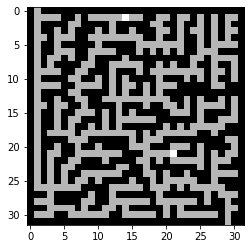

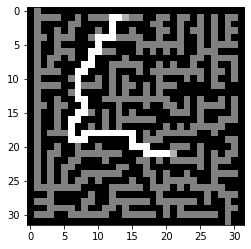

In [ ]:
plt.figure()
plt.imshow(x_pro[0,...,0], cmap='gray')
plt.show()
plt.imshow(y_pro[0,...,0], cmap='gray')
plt.show()

In [ ]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 100
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def resize(input_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image

In [ ]:
# Normalizing the images to [-1, 1]
def normalize(input_image):
  input_image = (input_image / 5) - 1
  return input_image

In [ ]:
def load_image_train(image_input):
  real_image = image_input
  #  real_image = resize(real_image,IMG_WIDTH,IMG_HEIGHT)
  real_image = normalize(real_image)

  return real_image

In [ ]:
train_x = np.array(list(map(load_image_train,x_pro)))
train_y = np.array(list(map(load_image_train,y_pro)))

train_x = tf.convert_to_tensor(train_x,dtype = tf.float32)
train_y = tf.convert_to_tensor(train_y,dtype = tf.float32)
#train_dataset = train_dataset.shuffle(BUFFER_SIZE)
#train_dataset = train_dataset.batch(BATCH_SIZE)

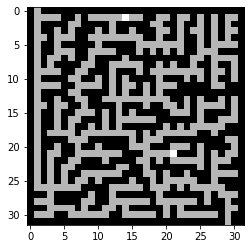

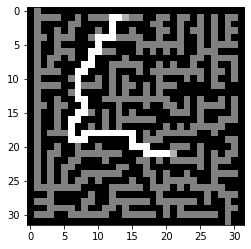

In [ ]:
plt.figure()
plt.imshow(x_pro[0,...,0], cmap='gray')
plt.show()
plt.imshow(y_pro[0,...,0], cmap='gray')
plt.show()

In [ ]:
print(np.max(train_x))
print(np.max(train_y))

0.4
1.0


In [ ]:
OUTPUT_CHANNELS = 1

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(train_x[0:10], 3))
print (down_result.shape)

(10, 32, 16, 1, 3)


In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[32, 32, 1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 16, 16, 64)
    downsample(128, 4),  # (batch_size, 8, 8, 128)
    downsample(256, 4),  # (batch_size, 4, 4, 256)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(256, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(128, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(64, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

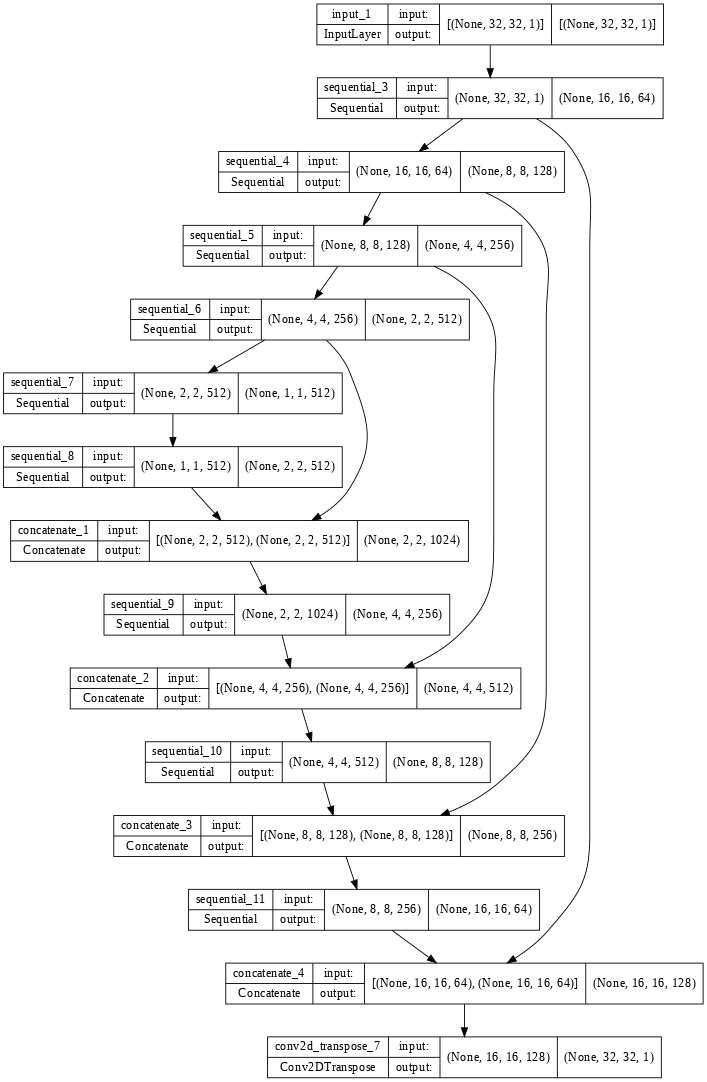

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

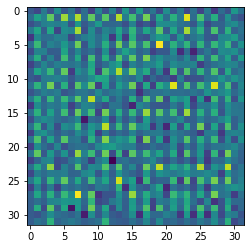

In [ ]:
gen_output = generator(train_x[0:10], training=False)
plt.imshow(gen_output[0, ...,0])

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[32, 32, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[32, 32, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 32, 32, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 16, 16, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 8, 8, 128)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)  # (batch_size,8, 8, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 3, 3, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

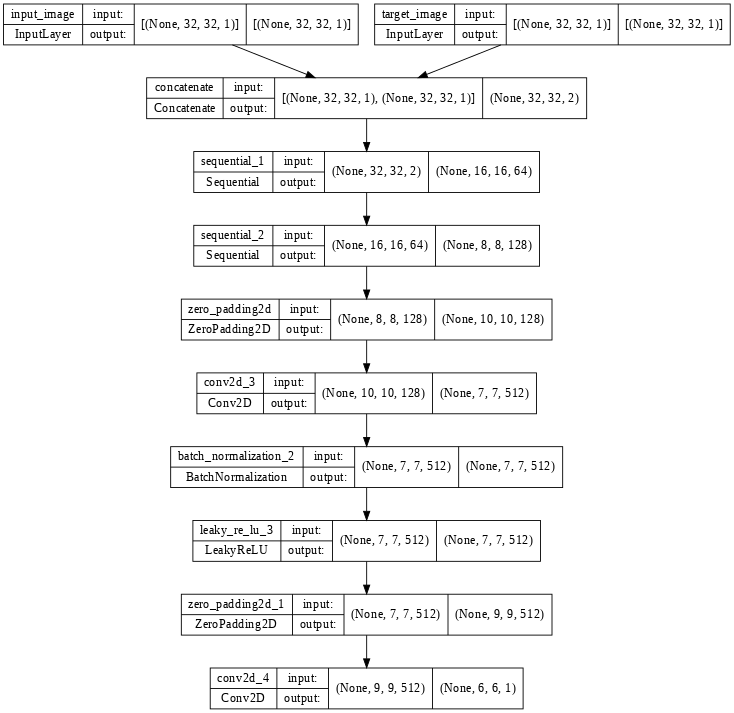

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
disc_out = discriminator([train_x[0:10, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

NameError: ignored

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

NameError: ignored

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0,...,0], tar[0,...,0], prediction[0,...,0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Test the function:

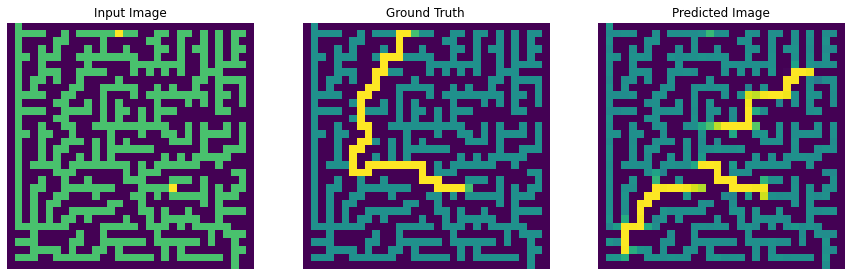

In [ ]:
generate_images(generator, train_x[0:10], train_y[0:10])

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [ ]:
import tqdm as  tqdm

In [ ]:
import random

In [ ]:
from pyparsing.core import null_debug_action
def fit(X, Y, steps):
  start = time.time()
  for epoch in range(steps):
    print("Epoch:",epoch,"\n")
    x_batch = []
    y_batch = []
    for i in tqdm.tqdm(range(0,x_train.shape[0],BATCH_SIZE), desc="Transfer progress", ncols=100, bar_format='{l_bar}{bar}|'):
      x_batch = X[i:i+BATCH_SIZE]
      y_batch = Y[i:i+BATCH_SIZE]
      if (epoch) % 10 and i > x_train.shape[0] - BATCH_SIZE:
        display.clear_output(wait=True)
        
        if epoch != 0:
          print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

        start = time.time()
        print(f"Step: {i//1000}k")

      train_step(x_batch, y_batch,i)
    k = random.randint(0,10)
    generate_images(generator, x_batch[np.newaxis,k], y_batch[np.newaxis,k])
      # Training step
      
      #print('.', end='', flush=True)

In [ ]:
discriminator = tf.keras.models.load_model("dis.h5")
generator = tf.keras.models.load_model("gen.h5")

In [ ]:
fit(train_x, train_y, steps=40000)

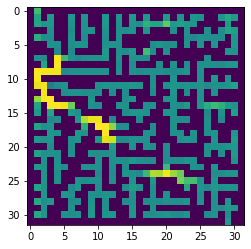

In [ ]:
show_x1 = generator(train_x[np.newaxis,1], training = True)
part = generator.conv
plt.imshow(show_x1[0,...,0])
plt.show()

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

In [ ]:
generator.save('saved_mode/gen.h5')
discriminator.save('saved_mode/dis.h5')